<a href="https://colab.research.google.com/github/NicholasLeotta99/Neuromatch_BrainCancer/blob/Nick/code/VGG19_Classifier_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Package Imports
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
#from torchsummary import summary

import os
#from google.colab import files
from PIL import Image
import subprocess

import random
random.seed(2023)
if torch.cuda.is_available():
  print("GPU is available")
else:
  print("GPU is not available")

if not os.path.isdir('./Model'):
    os.mkdir('./Model')
else:
    !rm ./Model/ -d -r
    os.mkdir('./Model')

GPU is available


In [2]:
# @title Data Loading
if os.path.isdir('./Training'):
    !rm ./Training/ -d -r
    !rm ./Testing/ -d -r
    !rm ./Validation/ -d -r
try:
    from google.colab import files
    if not os.path.isfile('./.kaggle/kaggle.json'):
        print('Upload kaggle.json account information to download the dataset:')
        files.upload()
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 /root/.kaggle/kaggle.json
except:
    print('Colab initialization failed')
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --force
!unzip -q brain-tumor-mri-dataset.zip 

Colab initialization failed
 98%|███████████████████████████████████████ | 145M/149M [00:03<00:00, 46.2MB/s]
100%|████████████████████████████████████████| 149M/149M [00:03<00:00, 43.6MB/s]


([<matplotlib.patches.Wedge at 0x7f54c4fb2b10>,
 [Text(0.8277837297324334, 0.724412932511742, 'pituitary'),
  Text(-0.6082475400461179, 0.9165341946855264, 'glioma'),
  Text(-0.8381134381616261, -0.7124365689469473, 'notumor'),
  Text(0.8172828984570812, -0.7362395424653533, 'meningioma')])

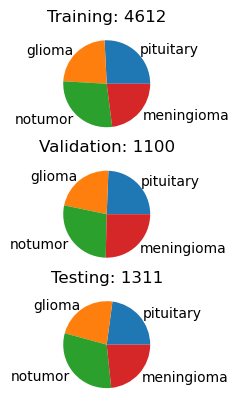

In [3]:
# @title Subsampling Validation Data

if not os.path.isdir('./Validation/'):
    os.mkdir('./Validation/')
    classes = os.listdir('./Training/')
    training_samples = []
    for i in classes:
        os.mkdir(f'./Validation/{i}/')
        files = os.listdir(f'./Training/{i}/')
        for f in files:
            training_samples.append(f'/{i}/{f}')
    random.seed(2023)
    random.shuffle(training_samples)
    validation_samples = training_samples[0:1100]
    training_samples = training_samples[1100:]
    for samp in validation_samples:
        os.rename(f'./Training{samp}', f'./Validation{samp}')

#Visualizing data class balance:
samples_train = []
samples_val = []
samples_test = []
for i in classes:
    samples_train.append(len(os.listdir(f'./Training/{i}/')))
    samples_val.append(len(os.listdir(f'./Validation/{i}/')))
    samples_test.append(len(os.listdir(f'./Testing/{i}/')))
plt.subplot(3,1,1)
plt.title(f'Training: {sum(samples_train)}')
plt.pie(samples_train, labels=classes)
plt.subplot(3,1,2)
plt.title(f'Validation: {sum(samples_val)}')
plt.pie(samples_val, labels=classes)
plt.subplot(3,1,3)
plt.title(f'Testing: {sum(samples_test)}')
plt.pie(samples_test, labels=classes)

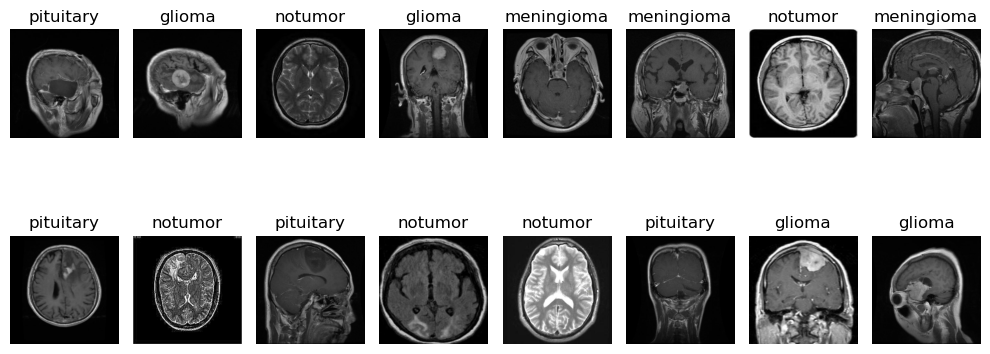

In [4]:
# @title Dataset Generation
#TODO - Verify labels correspond to classes
data_transf = transforms.Compose([
transforms.Resize((256, 256)),
transforms.ToTensor()])

TrainingDataset = ImageFolder(root='./Training/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
TrainingLoader = DataLoader(TrainingDataset, batch_size=16, shuffle=True)

ValidationDataset = ImageFolder(root='./Validation/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
ValidationLoader = DataLoader(ValidationDataset, batch_size=16, shuffle=True)

TestDataset = ImageFolder(root='./Testing/', transform=data_transf)#, transform=torchvision.models.VGG19_Weights.IMAGENET1K_V1.transforms)
TestLoader = DataLoader(TestDataset, batch_size=16, shuffle=True)

classes = os.listdir('./Training/')
for batch_number , (images, labels) in enumerate(TrainingLoader):
    plt.figure(figsize=(10,5))
    for i in range(0, images.shape[0]):
        plt.subplot(2, images.shape[0]//2, i+1)
        plt.imshow(torch.moveaxis(images[i], 0, -1))
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break

In [5]:
class Brain_Classifier():
    ''' Class to assist with training and evaluation of our Brain Tumor Classification model
    Args:
        model: loaded model to be utilized
        name: name for model, used to save checkpoints
    '''
    def __init__(self, model, name, train_dir='./Training', val_dir='./Validation', test_dir='./Testing'):
        # Saves model and model name to class
        self.Model = model
        self.name = name
        # Build data loaders
        self.build_loader(train_dir, val_dir, test_dir)
        # Initialize loss and optimizer
        self.loss_fn = torch.nn.CrossEntropyLoss()
        #self.optimizer = torch.optim.SGD(self.Model.parameters(), lr=0.005, momentum=.5)
        self.optimizer = torch.optim.Adam(self.Model.parameters(), lr=0.005)
        # Initialize counter for number of epochs trained
        self.trained_epochs = 0
        
    def build_loader(self, train_dir, val_dir, test_dir):
        '''Build the data loaders for training and evaluation
        Args:
            train_dir = path to training dir
            val_dir = path to validation dir
            test_dir = path to testing dir
        '''
        #Defining Transformations
        data_transf = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()])
        #Generating Loaders
        self.TrainData = DataLoader(ImageFolder(root=train_dir, transform=data_transf),
                             batch_size = 16, shuffle=True)
        self.ValData = DataLoader(ImageFolder(root=val_dir, transform=data_transf),
                             batch_size = 16, shuffle=True)
        self.TestData = DataLoader(ImageFolder(root=test_dir, transform=data_transf),
                             batch_size = 16, shuffle=True)
        
    def run_epoch(self, train=False, data='validation'):
        '''Run a single epoch
        Args:
            train = T or F : defines whether to update graph
            data = ['validaiton', 'train', 'test'] : defines which loader to utilize
        Returns:
            loss, accuracy
        '''
        #Loads necessary dataset from data string
        if data == 'train': dataset = self.TrainData
        elif data == 'validation': dataset = self.ValData
        elif data == 'test': dataset = self.TestData
        #Initialize counters for this epoch        
        current_loss = 0
        batch_accuracy = 0
        #For each batch
        for i, j in enumerate(dataset):
            if train: self.optimizer.zero_grad()
            #Load data, move to GPU
            inputs, labels = j
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
            #Obtain output from model, calculate loss and update weights (train=True)
            outputs = self.Model(inputs)
            loss = self.loss_fn(outputs, labels)
            if train: loss.backward(), self.optimizer.step()
            #Track loss and accuracy
            current_loss += loss.item()
            batch_accuracy += self.accuracy(outputs, labels)
        #Compute returned loss and accuracy
        return (current_loss / len(dataset.dataset)), (batch_accuracy / (i+1))
    
    def train(self, n_epochs, early_stop=False, patience=5):
        print(f'Adding {n_epochs} iterations to model training')
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []
        best_acc = 0
        patience_counter = 0
        for i in range(0, n_epochs):
            loss, acc = self.run_epoch(train=True, data='train')
            self.train_loss.append(loss)
            self.train_acc.append(acc)
            
            loss, acc = self.run_epoch(train=False, data='validation')
            self.val_loss.append(loss)
            self.val_acc.append(acc)
            
            self.trained_epochs += 1
            print(f'Trained {self.trained_epochs} epochs')
            print(f'Loss: {self.train_loss[-1]},  Accuracy: {self.train_acc[-1]}')
            print(f'Val Loss: {self.val_loss[-1]}, Val Accuracy: {self.val_acc[-1]}')
            if early_stop:
                if acc > best_acc:
                    best_acc = acc
                    print('New best model!')
                    self.checkpoint()
                    self.best_epochs = self.trained_epochs
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter == patience:
                        print('Out of patience, ending training...')
                        break
            self.plot_status()
        print(f'Loading best model (epoch {self.best_epochs})')
        self.Model.load_state_dict(torch.load(f'./Model/{self.name}_checkpoint.pth'))
        
    def accuracy(self, prediction, label):
        prediction = torch.argmax(prediction, axis=1)
        return ((prediction == label).sum()/len(label) * 100).cpu()

    def plot_status(self):
        plt.figure(figsize=(5,5))
        plt.subplot(2,1,1)
        plt.plot(self.train_loss, label='Training')
        plt.plot(self.val_loss, label='Validation')
        plt.title(f'Loss: Epoch {self.trained_epochs}')
        plt.legend()
        
        plt.subplot(2,1,2)
        plt.plot(self.train_acc, label='Training')
        plt.plot(self.val_acc, label='Validation')
        plt.title(f'Accuracy: Epoch {self.trained_epochs}')
        plt.legend()
        plt.draw()
    
    def checkpoint(self):
        torch.save(self.Model.state_dict(), f'./Model/{self.name}_checkpoint.pth')

Adding 20 iterations to model training


/home/nicholas/anaconda3/envs/Neuro/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Trained 1 epochs
Loss: 16591.87469565827,  Accuracy: 25.151384353637695
Val Loss: 0.0887525609406558, Val Accuracy: 24.15458869934082
New best model!
Trained 2 epochs
Loss: 0.08741785287340104,  Accuracy: 26.75172996520996
Val Loss: 0.08704325502569026, Val Accuracy: 26.177536010742188
New best model!
Trained 3 epochs
Loss: 0.08715683376902823,  Accuracy: 26.665224075317383
Val Loss: 0.0870410977710377, Val Accuracy: 26.479469299316406
New best model!
Trained 4 epochs
Loss: 0.08708868513702829,  Accuracy: 26.18944549560547
Val Loss: 0.0869628835808147, Val Accuracy: 27.294687271118164
New best model!
Trained 5 epochs
Loss: 0.08737326883173775,  Accuracy: 25.821800231933594
Val Loss: 0.08711733211170543, Val Accuracy: 26.117151260375977
Trained 6 epochs
Loss: 0.08692866959265802,  Accuracy: 26.665224075317383
Val Loss: 0.08681196754628961, Val Accuracy: 26.90217399597168
Trained 7 epochs
Loss: 0.08687435451116339,  Accuracy: 26.665224075317383
Val Loss: 0.08743035739118403, Val Accuracy

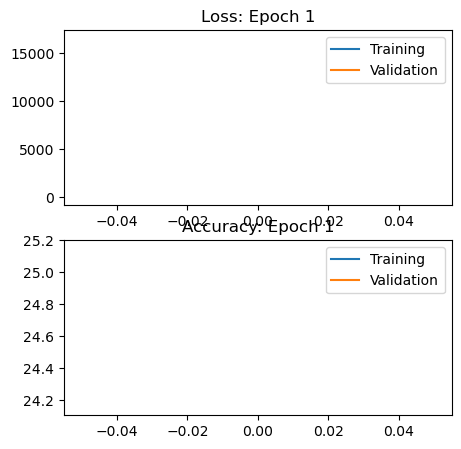

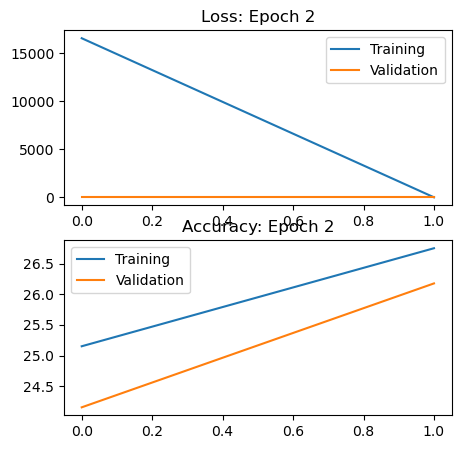

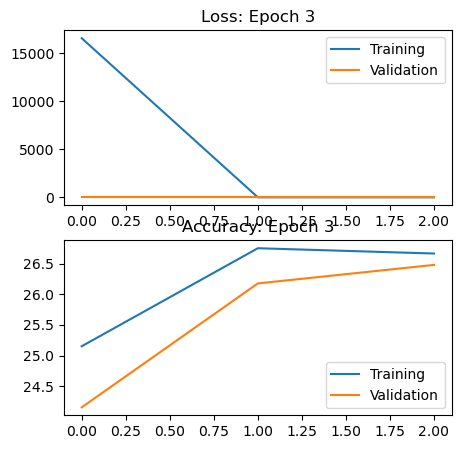

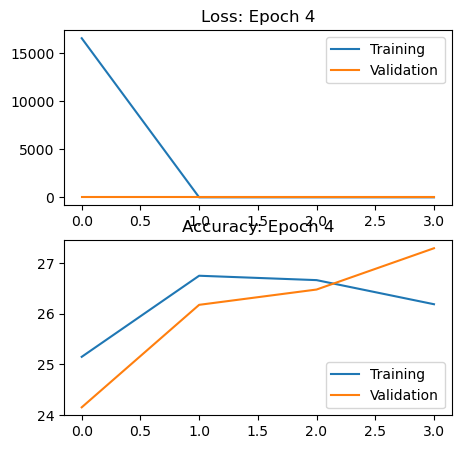

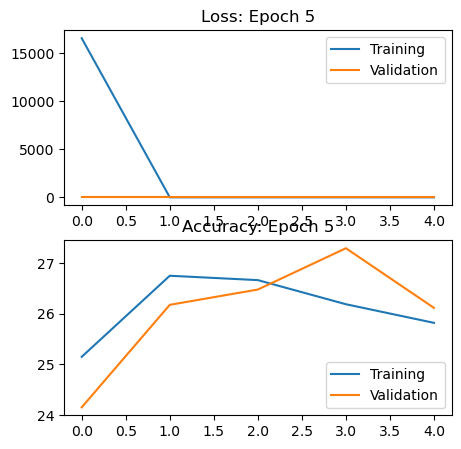

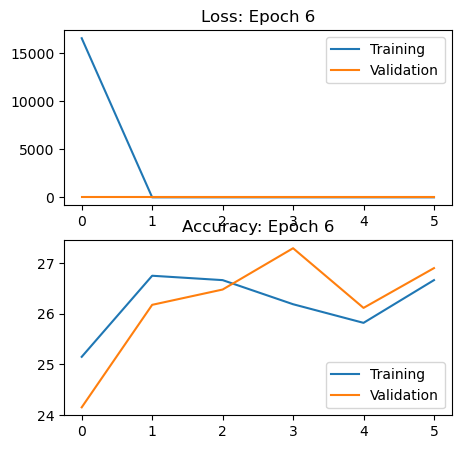

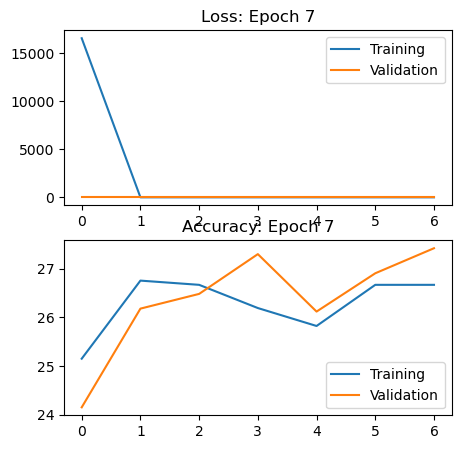

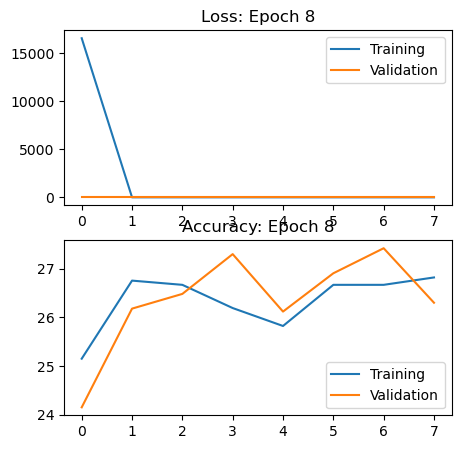

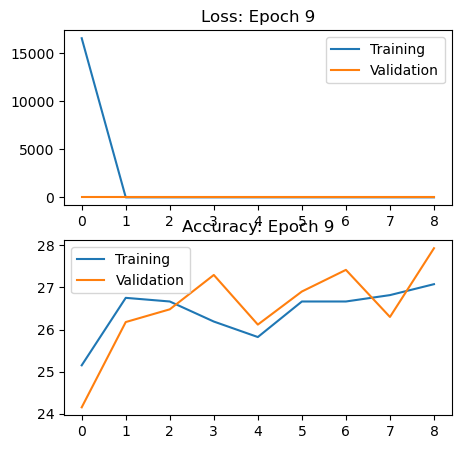

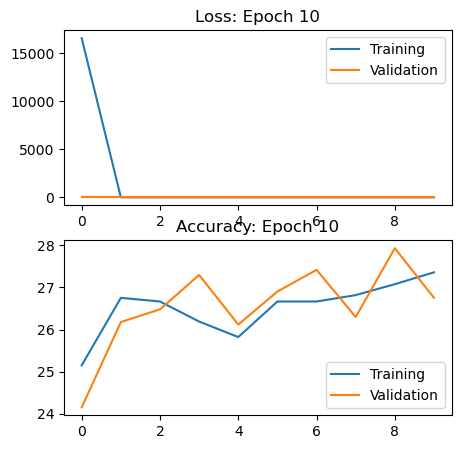

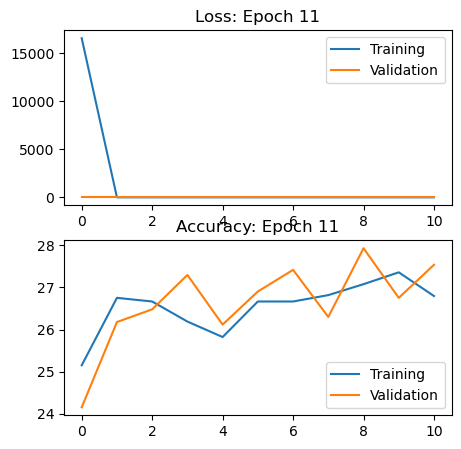

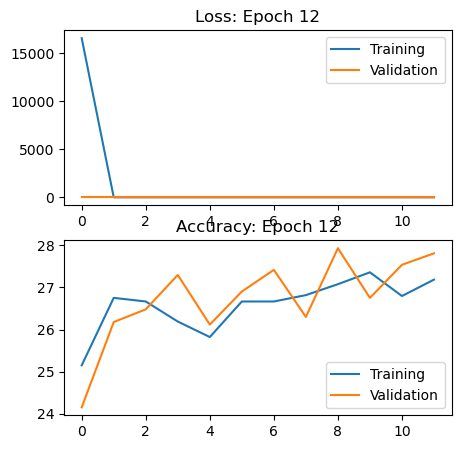

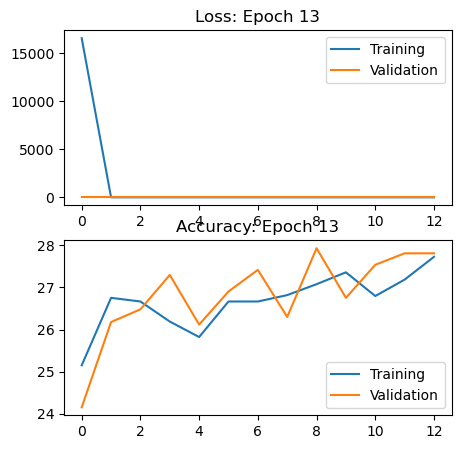

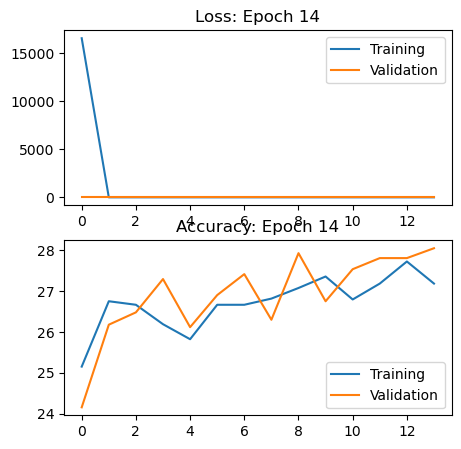

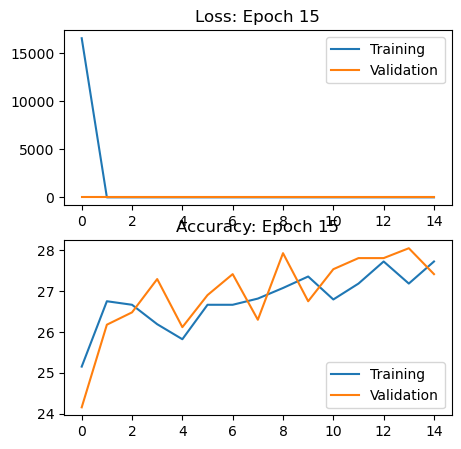

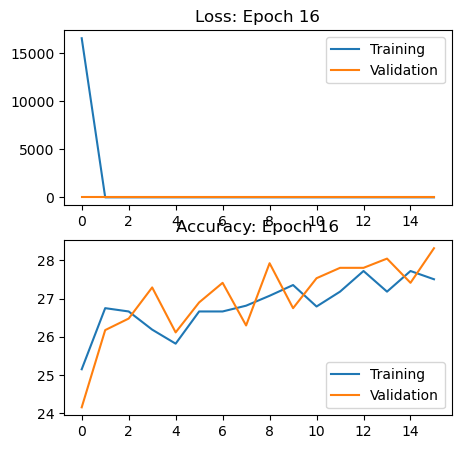

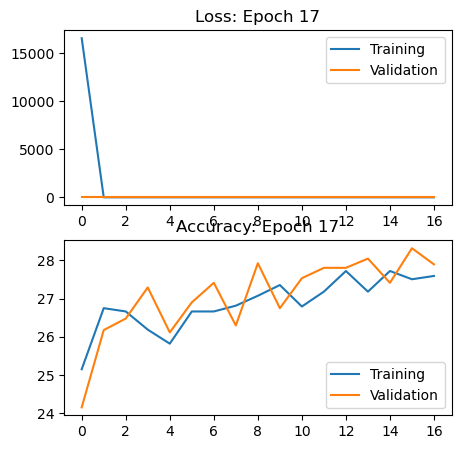

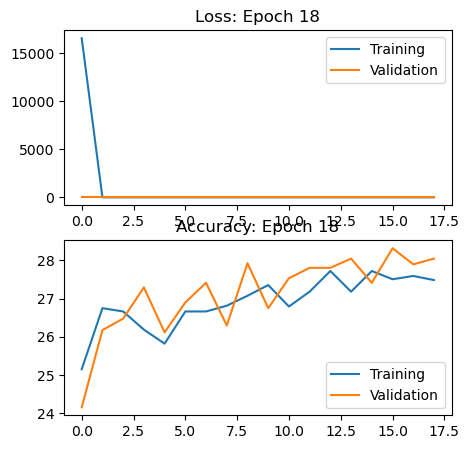

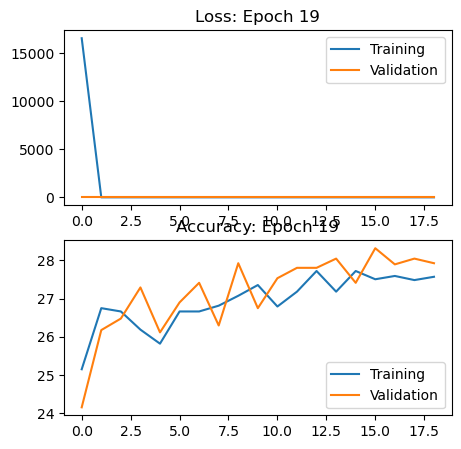

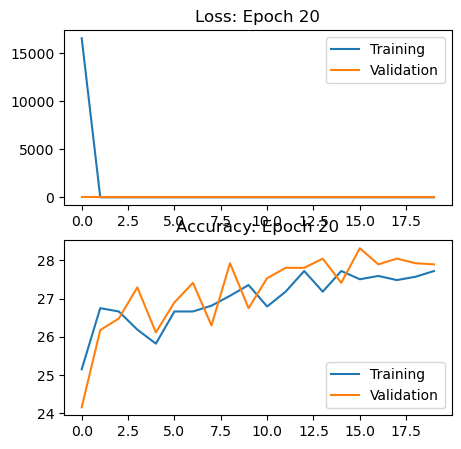

In [6]:
# @title Loading and training VGG
VGG = models.vgg19(weights='DEFAULT')

#Replace the classifying linear network with one with custom number of output classes
num_features = VGG.classifier[-1].in_features
VGG.classifier[-1] = nn.Linear(num_features, 4)
VGG.to('cuda')

A = Brain_Classifier(VGG, 'VGG')
A.train(20, early_stop=True)

/home/nicholas/anaconda3/envs/Neuro/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nicholas/anaconda3/envs/Neuro/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Adding 20 iterations to model training
Trained 1 epochs
Loss: 0.055031586745358095,  Accuracy: 66.9982681274414
Val Loss: 0.04037901741537181, Val Accuracy: 75.33212280273438
New best model!
Trained 2 epochs
Loss: 0.04049836243571454,  Accuracy: 75.1081314086914
Val Loss: 0.04178168329325589, Val Accuracy: 70.5313949584961
Trained 3 epochs
Loss: 0.03431852715831421,  Accuracy: 79.5198974609375
Val Loss: 0.032274934676560486, Val Accuracy: 79.136474609375
New best model!
Trained 4 epochs
Loss: 0.029160644700758787,  Accuracy: 82.85034942626953
Val Loss: 0.02812924755567854, Val Accuracy: 81.31038665771484
New best model!
Trained 5 epochs
Loss: 0.026118191605286813,  Accuracy: 84.58045196533203
Val Loss: 0.031636673716658896, Val Accuracy: 80.8272933959961
Trained 6 epochs
Loss: 0.02206410587331521,  Accuracy: 86.78633117675781
Val Loss: 0.0237191051651131, Val Accuracy: 86.29226684570312
New best model!
Trained 7 epochs
Loss: 0.017701202107743657,  Accuracy: 90.35466766357422
Val Loss: 

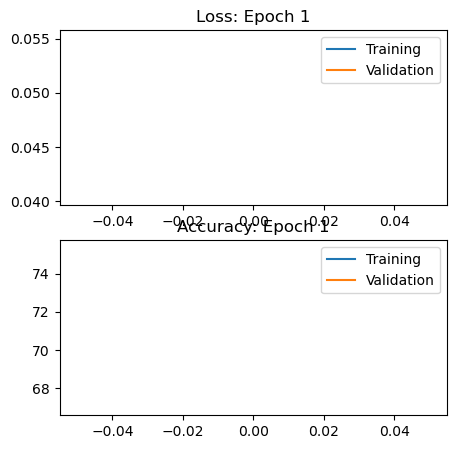

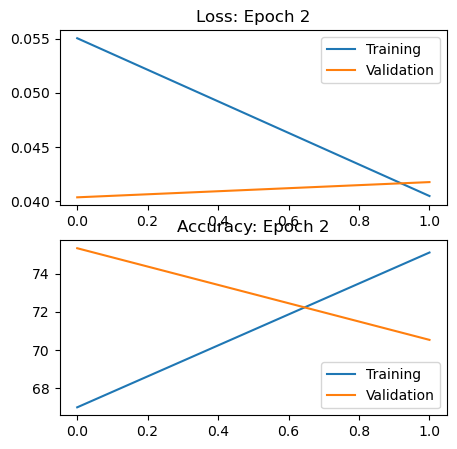

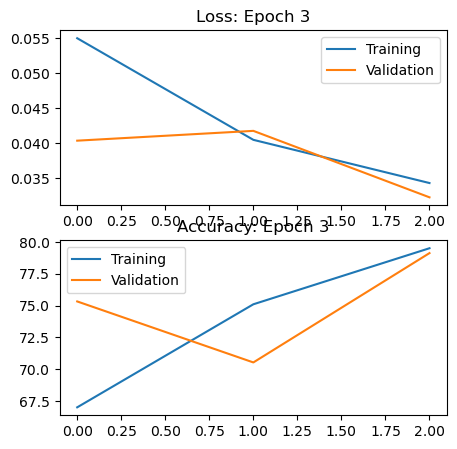

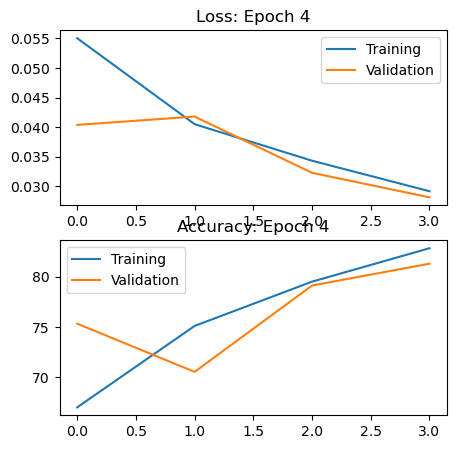

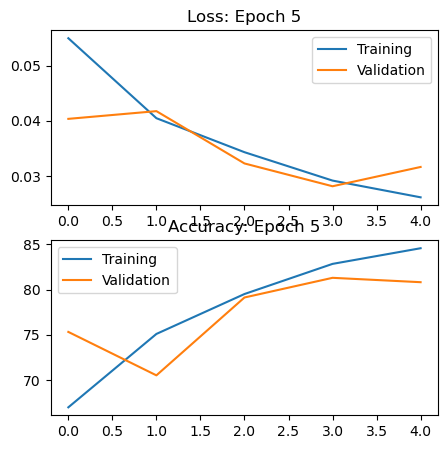

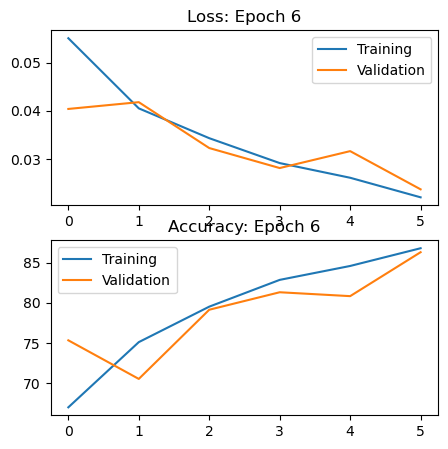

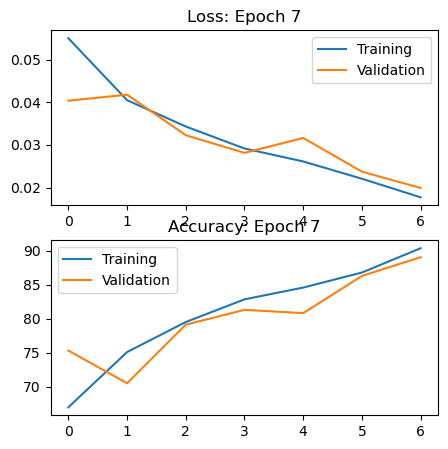

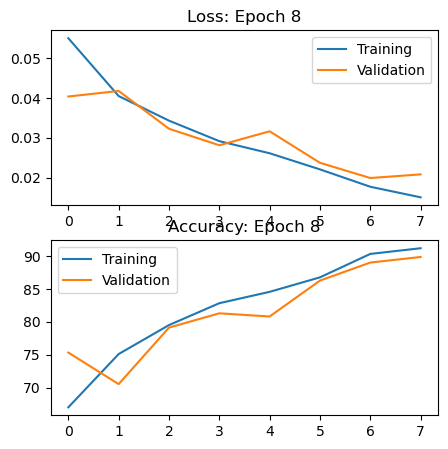

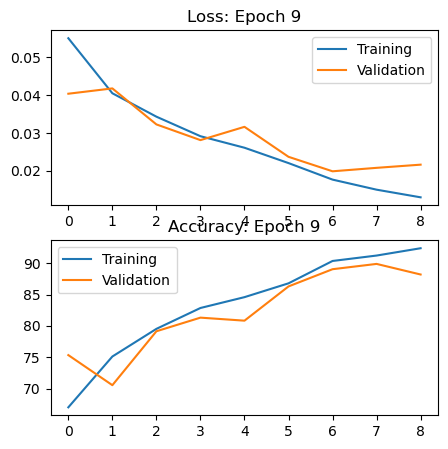

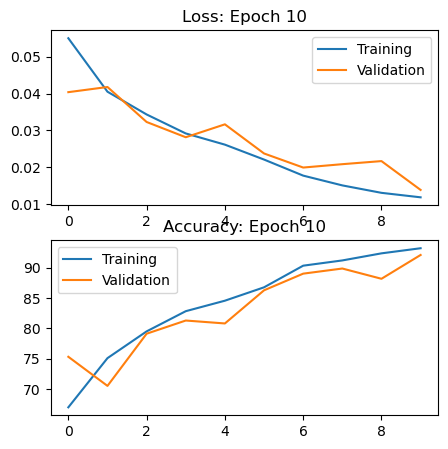

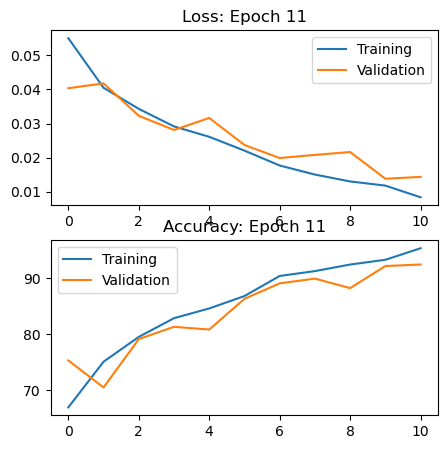

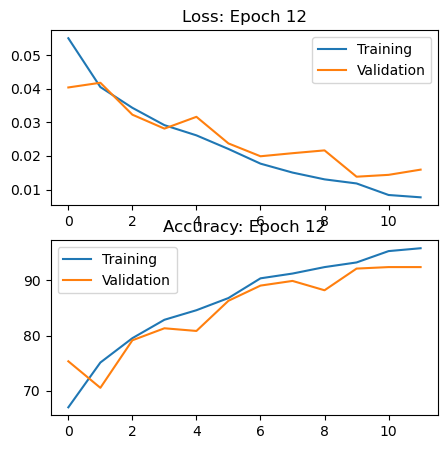

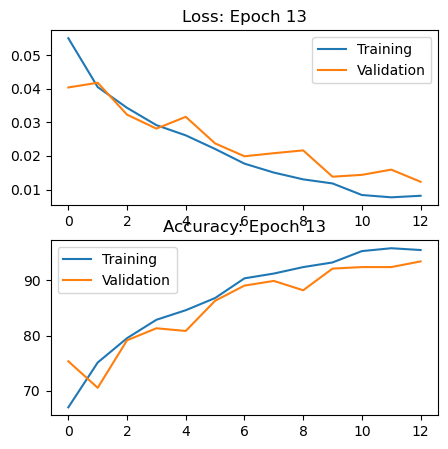

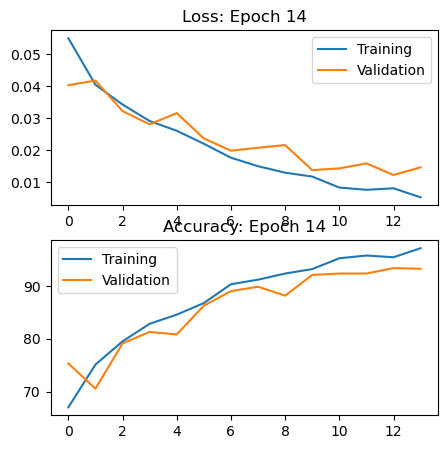

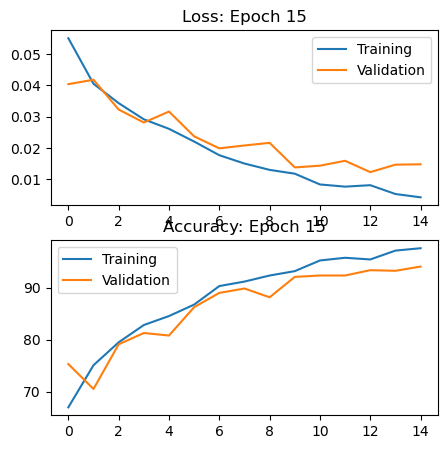

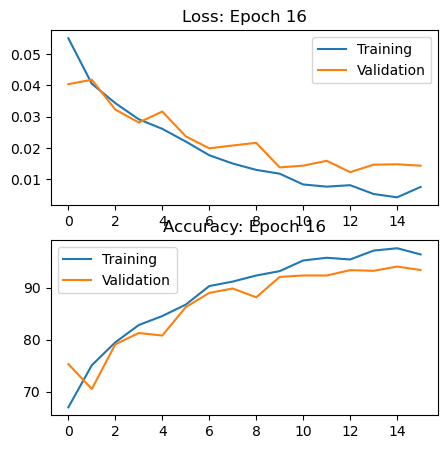

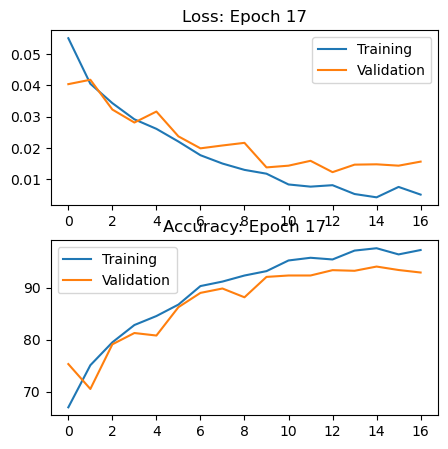

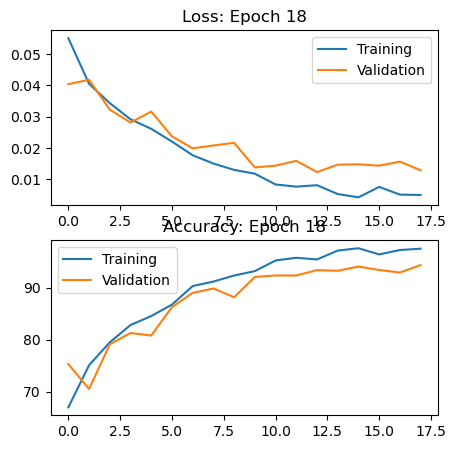

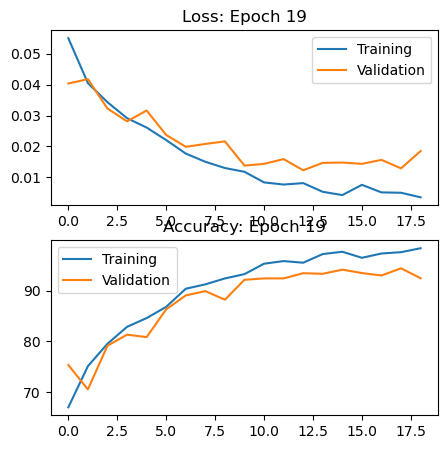

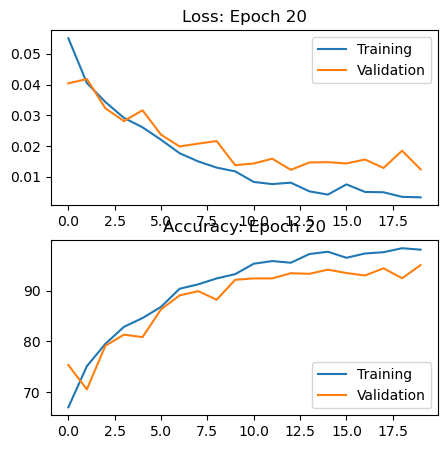

In [7]:
# @title Loading and training Resnet
resnet = models.resnet18(pretrained=True)

#Replace the classifying linear network with one with custom number of output classes
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 4)
resnet.to('cuda')

B = Brain_Classifier(resnet, 'resnet')
B.train(20, early_stop=True)